In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Dense(shape, activation="swish", use_bias=False),
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.LayerNormalization(),  # 因子标准化
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002)),
])

model.compile(optimizer=optimizers.Adam(0.0003), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=128
)
model.save('dnn')

Epoch 1/20
4720/4720 [==============================] - 144s 30ms/step - loss: 2.0585 - mae: 0.7206 - mape: 1942.9459 - val_loss: 1.0055 - val_mae: 0.7166 - val_mape: 1655.5565
Epoch 2/20
4720/4720 [==============================] - 145s 31ms/step - loss: 0.9159 - mae: 0.7055 - mape: 1137.0354 - val_loss: 0.9106 - val_mae: 0.7057 - val_mape: 3149.4744
Epoch 3/20
4720/4720 [==============================] - 145s 31ms/step - loss: 0.8923 - mae: 0.7041 - mape: 753.9980 - val_loss: 0.9049 - val_mae: 0.7061 - val_mape: 2387.0486
Epoch 4/20
4720/4720 [==============================] - 145s 31ms/step - loss: 0.8894 - mae: 0.7036 - mape: 610.9872 - val_loss: 0.9010 - val_mae: 0.7118 - val_mape: 1278.0007
Epoch 5/20
4720/4720 [==============================] - 147s 31ms/step - loss: 0.8887 - mae: 0.7034 - mape: 650.5995 - val_loss: 0.9006 - val_mae: 0.7101 - val_mape: 1091.4698
Epoch 6/20
4720/4720 [==============================] - 149s 32ms/step - loss: 0.8882 - mae: 0.7033 - mape: 722.1384 -

INFO:tensorflow:Assets written to: dnn\assets


INFO:tensorflow:Assets written to: dnn\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 33s 4ms/step


,predict
count,281840.000000
mean,-0.000080
std,0.002249
min,-0.024984
25%,-0.000808
50%,0.000107
75%,0.001090
max,0.009980


In [5]:
y_test.describe()

count    281840.000000
mean          0.000463
std           0.024988
min          -0.100000
25%          -0.012383
50%           0.000000
75%           0.011458
max           0.100000
Name: label, dtype: float64

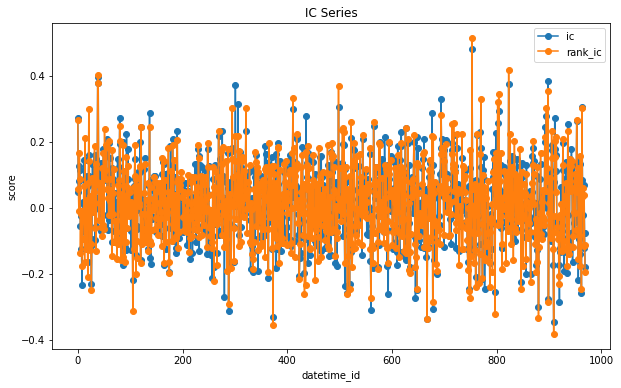

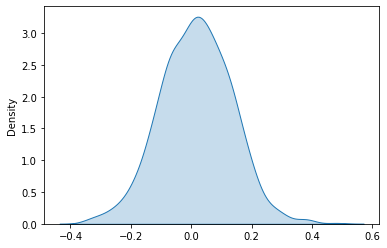

ic= 0.01586572580264963 icir= 0.13338679550263183 rank_ic= 0.010435908406461955 rank_icir= 0.08623661781434176


0.016829095923184365

In [6]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


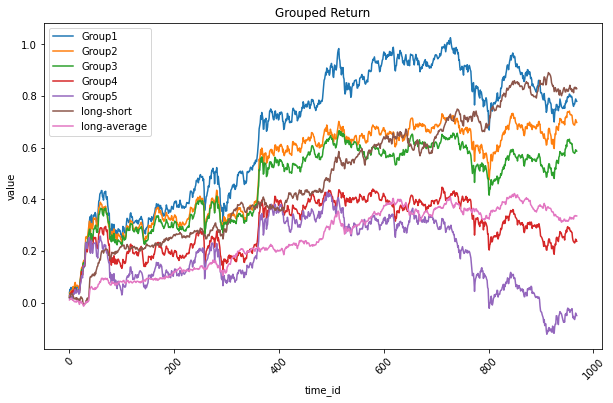

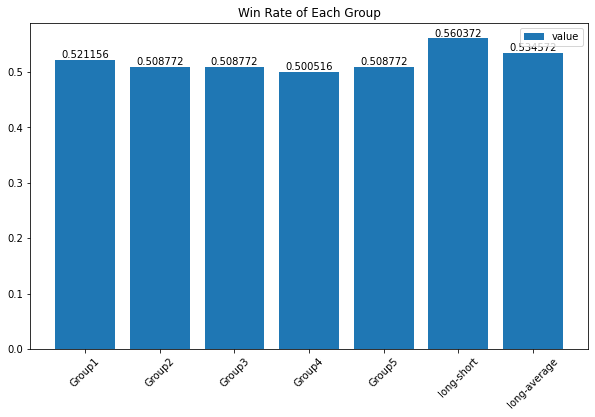

In [7]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='close', volume='vol')
report.group_return_ana(pred, y_test)